In [1]:
import cv2
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os
import scipy
import yaml
import random

In [18]:
# /home/sasha/WSLProjects/sem_simulator/data/Megaposit2_2iter_part12/Part 13/E200_F-0.15/G73_E200_F-0.15/mask_scunet

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit2_2iter_part11/E200_F-0.15/G73_E200_F-0.15

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0.30


# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0.60

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0.75

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F+0.15

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F+0.30

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F+0.45


# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F+0.60

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023/G73_E200_F-0.15

# /home/sasha/WSLProjects/sem_simulator/data/Megaposit2_2iter_part12/Part 16/G73_E320_F-0.15


# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0
# /home/sasha/WSLProjects/sem_simulator/data/Megaposit2_2iter_part11_MASKS/Megaposit2_2iter_part11/E200_F-0.15/G73_E200_F-0.15
# /home/sasha/WSLProjects/sem_simulator/data/Megaposit_4_waffer_2023_2/Megaposit2_2iter_part8/G73_E200_F-0.45

In [2]:
path_to_dir= "../sem_simulator/data/Megaposit2_2iter_part11_MASKS/Megaposit2_2iter_part11/E200_F-0.15/G73_E200_F-0.15/"

den_dir = os.path.join(path_to_dir, 'denoised')

bin_dir = os.path.join(path_to_dir, 'mask_scunet')
orig_dir = os.path.join(path_to_dir, 'raw')
# other = os.path.join(path_to_dir, 'mask_scunet_correct')
filenames_masks = os.listdir(bin_dir)
# filenames.sort()
print(f'Total: {len(filenames_masks)} files')
save_dir = os.path.join(path_to_dir, 'semantic_masks')
# save_dir = os.path.join(path_to_dir, 'semantic')

os.makedirs(save_dir, exist_ok=True)

Total: 51 files


In [4]:
filenames_masks = ['G73_C22_R3___35.png']

In [5]:
def detect_contour(img):
    cont, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    cont_image = np.zeros_like(img)
    cv2.drawContours(cont_image, cont, -1, 255, 0)
    plt.imshow(cont_image) 
    
    return cont, cont_image

In [110]:
def contour_offset(src, offset):
    return [tuple(np.array(point) + np.array(offset)) for point in src]

def does_contour_overlap(contour, other_contours, bin_mask):
    test = np.zeros_like(bin_mask)
    test1 = np.zeros_like(bin_mask)
    cv2.drawContours(test, [np.array(contour, dtype=np.int32)], -1, 128, -1)
    cv2.drawContours(test1, other_contours, -1, 128, -1)
    intersect = cv2.bitwise_and(test, test1)
    if len(np.unique(intersect)) > 1:
        return True
    return False
    # print(len(np.unique(intersect)))
    # return 1 in np.unique(intersect)

def scale_contour(src, scale, other_contours, bin_mask):
    rct = cv2.boundingRect(np.array(src))
    rct_offset = (-rct[0], -rct[1])
    dc_contour = contour_offset(src, rct_offset)
    dc_contour_scale = [tuple(np.array(point) * scale) for point in dc_contour]
    rct_scale = cv2.boundingRect(np.array(dc_contour_scale, dtype=np.int32))
    offset = ((rct[2] - rct_scale[2]) // 2, (rct[3] - rct_scale[3]) // 2)
    offset = tuple(np.array(offset) - np.array(rct_offset))
    dst = [tuple(np.array(point) + np.array(offset)) for point in dc_contour_scale]


    return dst

def scale_contours(src, bin_mask):
    dst = []
    for i, contour in enumerate(src):
        # print(type(src))
        other_contours = src[:i] + src[i+1:]  # Other contours except the current one

        if len(contour) > 160:
            scale_factor = random.uniform(1.1, 1.45)
        else:
            scale_factor = random.uniform(1.1, 1.6)
            
        scaled_contour = scale_contour(contour, scale_factor, other_contours, bin_mask)
        if scaled_contour is not None:
            if does_contour_overlap(scaled_contour, other_contours, bin_mask):
                print(len(scaled_contour))
                if len(scaled_contour) > 200:
                    scaled_contour = scale_contour(contour, scale_factor*0.5, other_contours, bin_mask)
                if len(scaled_contour) > 600:
                    scaled_contour = scale_contour(contour, scale_factor*0.3, other_contours, bin_mask)
                else:
                    scaled_contour = scale_contour(contour, scale_factor*0.8, other_contours, bin_mask)



            dst.append(scaled_contour)
    return dst

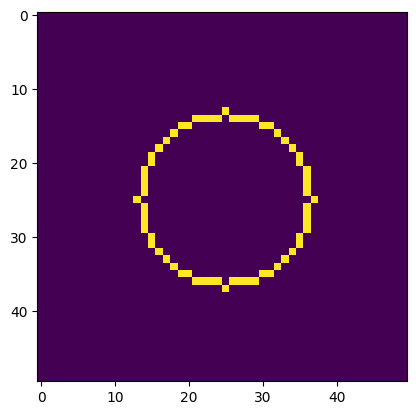

In [111]:
img = np.zeros((50,50), dtype=np.uint8)

cv2.circle(img, (25,25), 12, 128, 1)

plt.imshow(img)

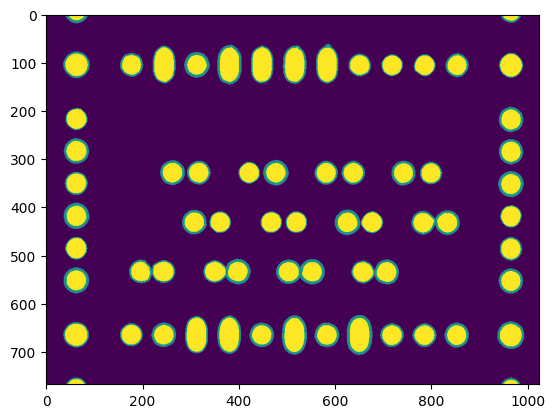

In [8]:
import skimage.morphology as morphology
for file_name in filenames_masks:
    bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
    # print(np.unique(bin_mask))
    # bin_mask = np.clip(morphology.remove_small_objects(bin_mask, 10), 0, 1) * 255
    # print(np.unique(bin_mask))

    # bin_mask = cv2.imread(os.path.join(bin_dir, 'G73_C24_R1___08.png'), 0)
    #
    # plt.imshow(bin_mask)
    cont, cont_image = detect_contour(bin_mask)
    # test = np.zeros_like(cont_image)
    for c in cont:
        offset = random.randint(3, 12)
        # print(offset)
        cv2.drawContours(cont_image, c, -1, 128, offset)
        



    # cv2.drawContours(cont_image, dst_np, -1, 128, -1)
    cv2.drawContours(cont_image, cont, -1, 255, -1)

    cv2.imwrite(os.path.join(save_dir, file_name), cont_image.astype(np.uint8))

    plt.imshow(cont_image)
    # break

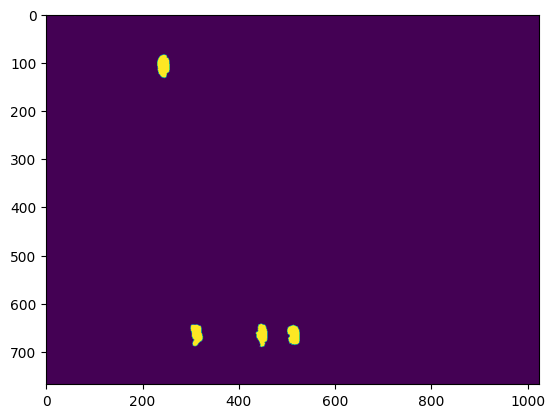

In [85]:
image = np.zeros((768, 1024), dtype=np.uint8)

cv2.drawContours(image, cont[-1], -1, 128, 3)
cv2.drawContours(image, cont, -1, 255, -1)
plt.imshow(image)

In [187]:
image[100:101, 300:400]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 128, 128, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 128, 128,
          0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

In [172]:
cont_image[350:351, 100:200]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [ ]:
['G73_C22_R3___35.png', 'G73_C24_R1___08.png', 'G73_C6_R2___15.png', 'G73_C9_R2___18.png']

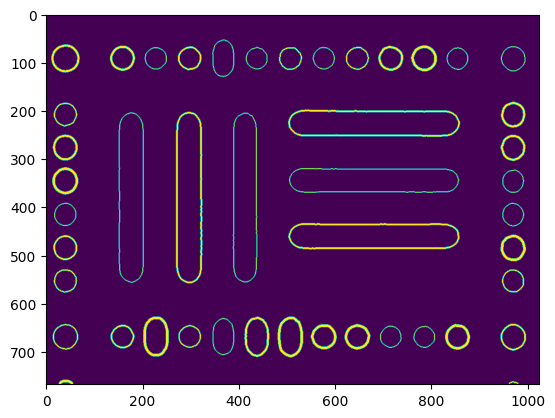

In [90]:
plt.imshow(cont_image == 128)

In [91]:
cont_image[350:351, 0:50]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        128, 128, 128, 128, 128, 128, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]],
      dtype=uint8)

175
999
672
718
168
737
116
115
115
168
113
174
168
113
727


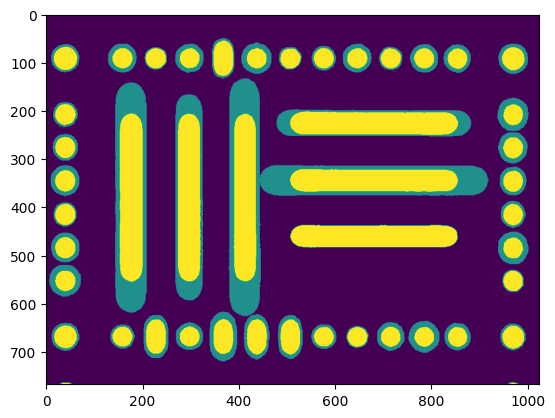

In [12]:
for file_name in filenames_masks:
    bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
    # plt.imshow(bin_mask)
    cont, cont_image = detect_contour(bin_mask)
    dst = scale_contours(cont, bin_mask)
    # print(dst)
    dst_np = [np.array(contour, dtype=np.int32) for contour in dst]

    cv2.drawContours(cont_image, dst_np, -1, 128, -1)
    cv2.drawContours(cont_image, cont, -1, 255, -1)

    # cv2.imwrite(os.path.join(save_dir, file_name), cont_image.astype(np.uint8))

    plt.imshow(cont_image)